In [12]:
from gensim.models import Word2Vec, KeyedVectors

import pandas as pd
import pandas_profiling
import numpy as np
np.set_printoptions(suppress=True, precision=3)
from datetime import datetime
import jieba
import re
import os

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import OneHotEncoder, scale, normalize, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, classification_report

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 8)
%matplotlib inline

# 数据加载

In [13]:
df = pd.read_csv('data/movie_comments.csv')

In [14]:
df.head()

,id,link,name,comment,star
0,1,https://movie.douban.com/subject/26363254/,战狼2,吴京意淫到了脑残的地步，看了恶心想吐,1
1,2,https://movie.douban.com/subject/26363254/,战狼2,首映礼看的。太恐怖了这个电影，不讲道理的，完全就是吴京在实现他这个小粉红的英雄梦。各种装备轮...,2
2,3,https://movie.douban.com/subject/26363254/,战狼2,吴京的炒作水平不输冯小刚，但小刚至少不会用主旋律来炒作…吴京让人看了不舒服，为了主旋律而主旋...,2
3,4,https://movie.douban.com/subject/26363254/,战狼2,凭良心说，好看到不像《战狼1》的续集，完虐《湄公河行动》。,4
4,5,https://movie.douban.com/subject/26363254/,战狼2,中二得很,1


In [15]:
df.describe()

,id,link,name,comment,star
count,261497,261497,261497,261495,261497
unique,260150,2761,2760,213970,11
top,12,https://movie.douban.com/subject/1849031/,当幸福来敲门 The Pursuit of Happyness,经典,4
freq,6,396,396,200,43002


# Helper Functions

In [16]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [17]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """对数损失度量（Logarithmic Loss  Metric）的多分类版本。
    :param actual: 包含actual target classes的数组
    :param predicted: 分类预测结果矩阵, 每个类别都有一个概率
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [18]:
# 评论的句子有点儿短，去掉一些停用词后可能丢失信息，试试不用停用词，简单去掉标点后分词
with open('data/stopwords.txt', 'r', encoding='utf-8') as f:
    STOPWORDS = set([line[:-1] for line in f.readlines()])

In [19]:
def clean_sentence_drop_stopwords(sentence):
    return list(set(jieba.cut(sentence)) - STOPWORDS)

In [20]:
def clean_sentence(sentence):
    result = []
    segment = re.findall('\d*\w+', sentence)
    result += [jieba.lcut(x) for x in segment]
    return [x for each in result for x in each if not x.isdigit()]

In [21]:
# trained_model
wiki_model_path = r"D:\Github\NLP\Artificial_Intelligence_for_NLP\Week_04_0727_word2vec\Assignment\word2vec_wiki.model"
wiki_model = Word2Vec.load(wiki_model_path)

In [22]:
# 使用句子中词汇的平均词向量作为句子词向量
def sentence_vector(sentence):
    flag = 0
    sentence_vec = np.zeros(wiki_model.vector_size)
    nums = len(sentence)
    for word in sentence:
        try:
            sentence_vec += wiki_model.wv[word]
            flag = 1
        except KeyError:
            nums -= 1
    return np.nan if not flag else sentence_vec / nums

# 预处理 

### star 属性应该只有1-5数字或者字符串选其一

In [23]:
df.star.unique()

array(['1', '2', '4', '5', '3', 'star', 4, 3, 5, 2, 1], dtype=object)

### 删除空评论与重复评论行

In [24]:
df_new = df.copy()
df_new.drop(df_new[df_new.star=='star'].index, inplace=True)
df_new.dropna(subset=['comment'],inplace=True)
df_new.drop_duplicates(subset=['comment'], inplace=True)
df_new.star = df_new.star.apply(lambda x: int(x))
df_new.reset_index(drop=True, inplace=True)
df_new.star.unique()

array([1, 2, 4, 5, 3], dtype=int64)

### 分词

In [25]:
df_new['clean_comment'] = df_new.comment.apply(clean_sentence)

Building prefix dict from the default dictionary ...
I0913 22:28:41.598145 13540 __init__.py:111] Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
I0913 22:28:41.602144 13540 __init__.py:131] Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.909 seconds.
I0913 22:28:42.510141 13540 __init__.py:163] Loading model cost 0.909 seconds.
Prefix dict has been built succesfully.
I0913 22:28:42.513142 13540 __init__.py:164] Prefix dict has been built succesfully.


### 从用平均词向量构建句子向量

In [26]:
df_new['comment_vec'] = df_new.clean_comment.apply(sentence_vector)

In [27]:
df_new.tail()

,id,link,name,comment,star,clean_comment,comment_vec
213964,260145,https://movie.douban.com/subject/1441763/,不羁美少年 À cause d'un garçon,内容只能说一般。。女性角色怎么都这么悲催啊！！不过男猪脚很帅,3,"[内容, 只能, 说, 一般, 女性, 角色, 怎么, 都, 这么, 悲, 催, 啊, 不过...","[-0.9653091602958739, -0.5943305254913867, -0...."
213965,260146,https://movie.douban.com/subject/1441763/,不羁美少年 À cause d'un garçon,翘了三天班就窝在家里看小基片惹（手动拜拜.gif,3,"[翘, 了, 三天, 班, 就, 窝, 在, 家里, 看小, 基片, 惹, 手动, 拜拜, ...","[-0.1373161240057512, -0.9519095800139687, 1.0..."
213966,260147,https://movie.douban.com/subject/1441763/,不羁美少年 À cause d'un garçon,我喜欢女主角，希腊雕塑一般的面庞与身体。（在一部同志题材的电影中迷恋女主角好像很不应该吧）,2,"[我, 喜欢, 女主角, 希腊, 雕塑, 一般, 的, 面庞, 与, 身体, 在, 一部, ...","[-0.49309063826998073, -0.4821888374475141, -0..."
213967,260148,https://movie.douban.com/subject/1441763/,不羁美少年 À cause d'un garçon,冲着颜值还可以看下去,3,"[冲着, 颜值, 还, 可以, 看, 下去]","[-0.23062036807338396, -0.8813576425115267, -0..."
213968,260149,https://movie.douban.com/subject/1441763/,不羁美少年 À cause d'un garçon,除了主人公都不帅，女主挺漂亮之外……唯一的感觉就是他男朋友真让人恶心,3,"[除了, 主人公, 都, 不帅, 女主挺, 漂亮, 之外, 唯一, 的, 感觉, 就是, 他...","[-1.4769697139660518, 0.1903096747895082, -0.6..."


### 删除转化后comment_vec为nan的行

In [28]:
df_new.dropna(subset=['comment_vec'], inplace=True)
df_new.reset_index(drop=True, inplace=True)
df_new.tail()

,id,link,name,comment,star,clean_comment,comment_vec
206863,260145,https://movie.douban.com/subject/1441763/,不羁美少年 À cause d'un garçon,内容只能说一般。。女性角色怎么都这么悲催啊！！不过男猪脚很帅,3,"[内容, 只能, 说, 一般, 女性, 角色, 怎么, 都, 这么, 悲, 催, 啊, 不过...","[-0.9653091602958739, -0.5943305254913867, -0...."
206864,260146,https://movie.douban.com/subject/1441763/,不羁美少年 À cause d'un garçon,翘了三天班就窝在家里看小基片惹（手动拜拜.gif,3,"[翘, 了, 三天, 班, 就, 窝, 在, 家里, 看小, 基片, 惹, 手动, 拜拜, ...","[-0.1373161240057512, -0.9519095800139687, 1.0..."
206865,260147,https://movie.douban.com/subject/1441763/,不羁美少年 À cause d'un garçon,我喜欢女主角，希腊雕塑一般的面庞与身体。（在一部同志题材的电影中迷恋女主角好像很不应该吧）,2,"[我, 喜欢, 女主角, 希腊, 雕塑, 一般, 的, 面庞, 与, 身体, 在, 一部, ...","[-0.49309063826998073, -0.4821888374475141, -0..."
206866,260148,https://movie.douban.com/subject/1441763/,不羁美少年 À cause d'un garçon,冲着颜值还可以看下去,3,"[冲着, 颜值, 还, 可以, 看, 下去]","[-0.23062036807338396, -0.8813576425115267, -0..."
206867,260149,https://movie.douban.com/subject/1441763/,不羁美少年 À cause d'un garçon,除了主人公都不帅，女主挺漂亮之外……唯一的感觉就是他男朋友真让人恶心,3,"[除了, 主人公, 都, 不帅, 女主挺, 漂亮, 之外, 唯一, 的, 感觉, 就是, 他...","[-1.4769697139660518, 0.1903096747895082, -0.6..."


# 模型

## Logistics Regression

In [29]:
X = np.array(df_new.comment_vec.tolist())
y = df_new.star
train_valid_X, test_X, train_valid_y, test_y = train_test_split(X, y, test_size=.2)
print('all datasets:\t\t', X.shape, y.shape)
print('train_valid_datasets:\t', train_valid_X.shape, train_valid_y.shape)
print('test_datasets:\t\t', test_X.shape, test_y.shape)

all datasets:		 (206868, 200) (206868,)
train_valid_datasets:	 (165494, 200) (165494,)
test_datasets:		 (41374, 200) (41374,)


In [30]:
log_clf = LogisticRegression()
log_clf.fit(train_valid_X, train_valid_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
ypred = log_clf.predict(train_valid_X)
print(classification_report(train_valid_y, ypred))

              precision    recall  f1-score   support

           1       0.39      0.23      0.28     15753
           2       0.30      0.02      0.03     18277
           3       0.36      0.34      0.35     41924
           4       0.37      0.70      0.49     52972
           5       0.43      0.21      0.28     36568

    accuracy                           0.38    165494
   macro avg       0.37      0.30      0.29    165494
weighted avg       0.38      0.38      0.34    165494



In [336]:
conf_mat = confusion_matrix(train_valid_y, ypred)

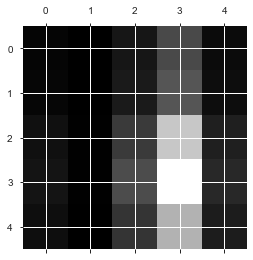

In [345]:
plt.matshow(conf_mat, cmap=plt.cm.gray)
plt.show()

## SGDClassifier

In [32]:
sgd_clf = SGDClassifier()
sgd_clf.fit(train_valid_X, train_valid_y)
ypred_sgd = sgd_clf.predict(train_valid_X)
print(classification_report(train_valid_y, ypred_sgd))

              precision    recall  f1-score   support

           1       0.29      0.20      0.23     15753
           2       0.15      0.05      0.08     18277
           3       0.27      0.80      0.41     41924
           4       0.41      0.12      0.18     52972
           5       0.40      0.11      0.17     36568

    accuracy                           0.29    165494
   macro avg       0.30      0.26      0.21    165494
weighted avg       0.33      0.29      0.23    165494



## RandomForest

In [38]:
rf_clf = RandomForestClassifier()
rf_clf.fit(train_valid_X, train_valid_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [40]:
ypred_rf = rf_clf.predict(train_valid_X)
print(classification_report(train_valid_y, ypred_rf))

              precision    recall  f1-score   support

           1       0.98      0.97      0.98     15753
           2       0.98      0.97      0.97     18277
           3       0.97      0.98      0.98     41924
           4       0.97      0.98      0.98     52972
           5       0.98      0.97      0.97     36568

    accuracy                           0.98    165494
   macro avg       0.98      0.97      0.98    165494
weighted avg       0.98      0.98      0.98    165494



In [54]:
ypred_rf[:30], train_valid_y[:30].to_numpy()

(array([2, 5, 3, 5, 2, 3, 4, 5, 3, 2, 4, 4, 4, 3, 3, 3, 5, 3, 1, 4, 1, 2,
        1, 5, 4, 5, 1, 2, 4, 1], dtype=int64),
 array([2, 5, 3, 5, 2, 3, 4, 5, 3, 2, 4, 4, 4, 3, 3, 3, 5, 3, 1, 4, 1, 2,
        1, 5, 4, 5, 1, 2, 4, 1], dtype=int64))

### 严重过拟合

In [35]:
cross_val_score(rf_clf, train_valid_X, train_valid_y, cv=5)

array([0.306, 0.305, 0.307, 0.31 , 0.305])

In [37]:
ypred_test_rf = rf_clf.predict(test_X)
print(classification_report(test_y, ypred_test_rf))

              precision    recall  f1-score   support

           1       0.23      0.17      0.20      3931
           2       0.16      0.10      0.13      4631
           3       0.29      0.36      0.32     10311
           4       0.35      0.42      0.38     13232
           5       0.31      0.22      0.26      9269

    accuracy                           0.30     41374
   macro avg       0.27      0.26      0.26     41374
weighted avg       0.29      0.30      0.29     41374



### 查看预测与实际不符的评论

In [80]:
predict_star = pd.DataFrame(ypred_test_rf, columns=['predict_star'])
origin_df = df_new.iloc[test_y.index][['comment', 'star']]
origin_df.reset_index(drop=True, inplace=True)

In [82]:
temp_df = pd.concat([origin_df, predict_star], axis=1)
temp_df[(temp_df.star != temp_df.predict_star)]                           

,comment,star,predict_star
1,很不错的老片子，值得一看,4,5
2,一般，小猪很可爱,2,3
3,影片一般吧，可能大了不怎么喜欢,2,3
6,不太喜欢这种主题，并不touchme!,2,3
7,画面很美。青涩的恋歌,3,5
8,哈哈，从小看到大永不厌倦的好片,5,4
9,看到最后虽然没有哭，但是还是有点心痛啊，嗯，泰语是真的不好听……,5,2
10,小羅莉能搞定壞叔叔?~存疑~,3,4
11,后面那段矿道追车戏很不错,3,4
12,最新清一色的5星水军，夸得好尴尬,1,4


分析错判的可能原因：

讽刺的语句无法判定

简短的评论无法提取有效情感信息

## XGBClassifier

In [48]:
xgb_clf = XGBClassifier()
xgb_clf.fit(train_valid_X, train_valid_y)

In [49]:
ypred_xgb = xgb_clf.predict(train_valid_X)

In [50]:
print(classification_report(train_valid_y, ypred_xgb))

              precision    recall  f1-score   support

           1       0.44      0.16      0.24     15753
           2       0.33      0.00      0.00     18277
           3       0.36      0.35      0.35     41924
           4       0.37      0.73      0.50     52972
           5       0.45      0.19      0.27     36568

    accuracy                           0.38    165494
   macro avg       0.39      0.29      0.27    165494
weighted avg       0.39      0.38      0.33    165494



## NeuralNetwork with TensorFlow

In [309]:
def log_dir(prefix=''):
    now = datetime.now().strftime('%Y%m%d_%H%M%S')
    root_logdir = 'tf_logs'
    if prefix:
        prefix += '-'
    name = prefix + 'run_' + now
    return os.path.join(root_logdir, name)


logdir = log_dir('douban_comment')

In [350]:
def train(train_flatten, train_labels, test_flatten, test_labels):
    reset_graph()
    checkpoint_path = 'tmp/douban_comment'
    units = 200
    initial_learning_rate = .1
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                                                                 decay_steps=10000,
                                                                 decay_rate=.96,
                                                                 staircase=True)

    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     monitor='val_acc',
                                                     verbose=1,
                                                     save_best_only=True,
                                                     load_weights_on_restart=True)
    stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc',
                                                     mode='max',
                                                     patience=3)
    csv_logger = tf.keras.callbacks.CSVLogger('csv_logger')
    tensorboard = tf.keras.callbacks.TensorBoard(logdir)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(4 * units, activation=tf.nn.relu, input_shape=(200, )),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(2 * units, activation=tf.nn.relu),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(units, activation=tf.nn.relu),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(5, activation=tf.nn.softmax)
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(lr_schedule),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(train_flatten, train_labels, validation_split=.2,
              epochs=100, batch_size=1024, callbacks=[cp_callback,
                                     stop_callback,
                                     csv_logger,
                                     tensorboard])

    print("Model's performance on test dataset:")
    print(f"Test accuracy: {model.evaluate(test_flatten, test_labels)[1] * 100:.3f}%")
    model.save('final_model.h5')

In [328]:
encoder = OneHotEncoder()
train_valid_y_1hot = encoder.fit_transform(train_valid_y.to_numpy().reshape(-1,1))
test_y_1hot = encoder.fit_transform(test_y.to_numpy().reshape(-1,1))
train_valid_y_1hot.shape, test_y_1hot.shape

((196272, 5), (49069, 5))

In [351]:
reset_graph()
train(train_valid_X, train_valid_y_1hot, test_X, test_y_1hot)

Train on 157017 samples, validate on 39255 samples
Epoch 1/100
156672/157017 [============================>.] - ETA: 0s - loss: 1.5631 - acc: 0.3093
Epoch 00001: val_acc improved from -inf to 0.31988, saving model to tmp/douban_comment
157017/157017 [==============================] - 11s 72us/sample - loss: 1.5629 - acc: 0.3093 - val_loss: 1.5183 - val_acc: 0.3199
Epoch 2/100
156672/157017 [============================>.] - ETA: 0s - loss: 1.5180 - acc: 0.3215
Epoch 00002: val_acc improved from 0.31988 to 0.31996, saving model to tmp/douban_comment
157017/157017 [==============================] - 11s 71us/sample - loss: 1.5180 - acc: 0.3215 - val_loss: 1.5156 - val_acc: 0.3200
Epoch 3/100
156672/157017 [============================>.] - ETA: 0s - loss: 1.5138 - acc: 0.3220- ETA: 1s - 
Epoch 00003: val_acc did not improve from 0.31996
157017/157017 [==============================] - 10s 63us/sample - loss: 1.5139 - acc: 0.3221 - val_loss: 1.5148 - val_acc: 0.3198
Epoch 4/100
156672/1570